In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)
prices = pd.read_csv('datasets\FB-stock-prices.csv')
print(prices.dtypes)
prices.head()

Date     object
Price     int64
dtype: object


,Date,Price
0,1/4/2021,269
1,1/5/2021,271
2,1/6/2021,263
3,1/7/2021,269
4,1/8/2021,268


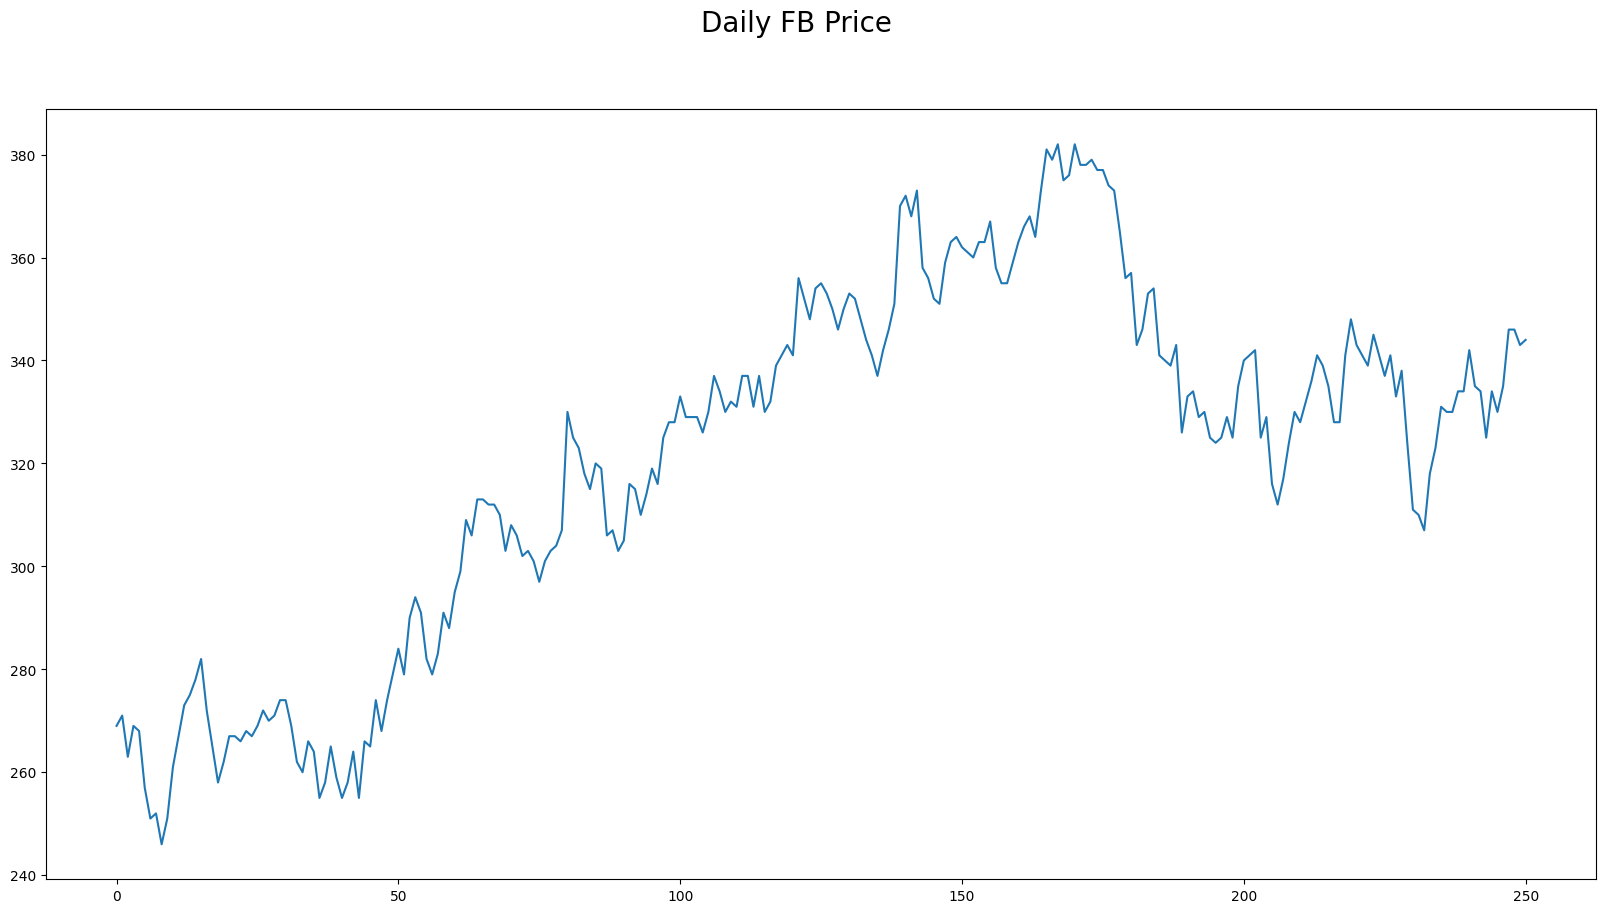

In [3]:
plt.figure(figsize=(20,10)).suptitle("Daily FB Price", fontsize=20)
plt.plot(prices["Price"])
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaled_prices=scaler.fit_transform(prices[["Price"]].values)


total_size = len(scaled_prices)
test_size = 50
train_size = total_size - test_size
print(train_size, test_size)

training_prices = scaled_prices[0:train_size,:]
test_prices = scaled_prices[train_size:,:]

print(training_prices.shape, test_prices.shape)

201 50
(201, 1) (50, 1)


In [8]:
def create_rnn_dataset(data, lookback=1):
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

lookback=25 #lookback for 25 previous days

#Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(training_prices,lookback)

#Reshape for use with RNN
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (175, 1, 25) (175,)


In [10]:
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense
import tensorflow as tf
tf.random.set_seed(3)

price_model=Sequential()
price_model.add(SimpleRNN(32, input_shape=(1,lookback)))
price_model.add(Dense(1))
price_model.compile(loss="mean_squared_error",optimizer="adam",metrics=["mse"])
price_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1856      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
_________________________________________________________________


In [21]:
price_model.fit(train_req_x, train_req_y, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
175/175 [==============================] - 0s 772us/step - loss: 0.0389 - mse: 0.0389
Epoch 2/5
175/175 [==============================] - 0s 757us/step - loss: 0.0367 - mse: 0.0367
Epoch 3/5
175/175 [==============================] - 0s 745us/step - loss: 0.0336 - mse: 0.0336
Epoch 4/5
175/175 [==============================] - 0s 738us/step - loss: 0.0335 - mse: 0.0335
Epoch 5/5
175/175 [==============================] - 0s 794us/step - loss: 0.0347 - mse: 0.0347


In [22]:
#Preprocess the test dataset, the same way training set is processed
test_req_x, test_req_y = create_rnn_dataset(test_prices,lookback)
print(test_req_x.shape, test_req_y.shape)
test_req_x = np.reshape(test_req_x,(test_req_x.shape[0],1, test_req_x.shape[1]))
price_model.evaluate(test_req_x, test_req_y, verbose=1)
predict_on_test = price_model.predict(test_req_x)
predict_on_test = scaler.inverse_transform(predict_on_test)

(24, 25) (24,)
1/1 [==============================] - 0s 15ms/step


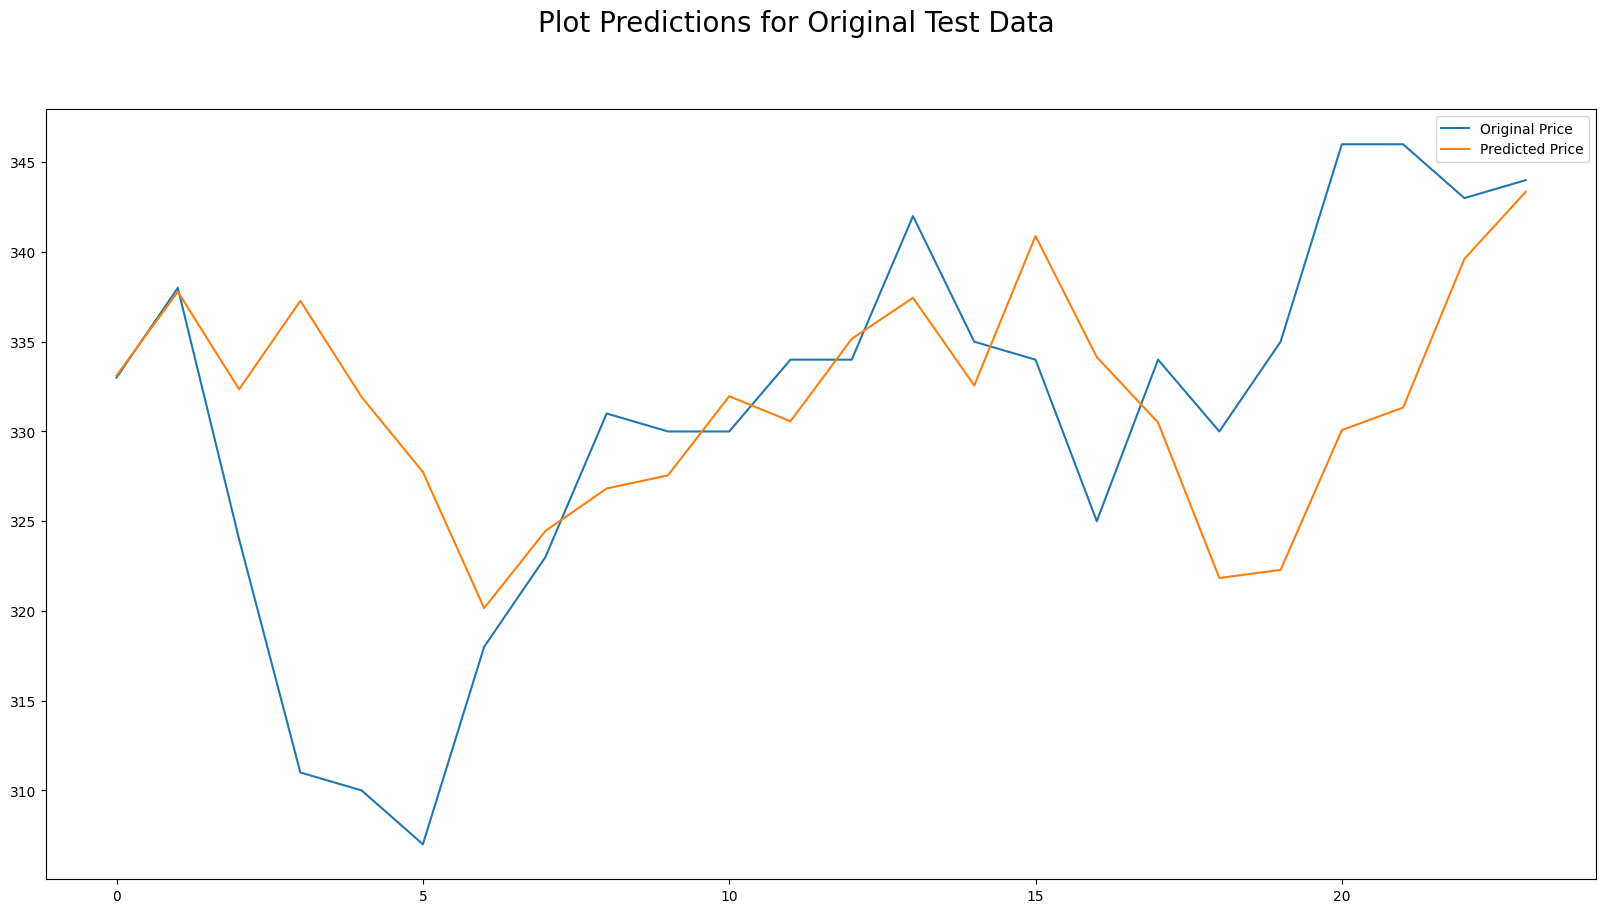

In [24]:
orig_test_values = prices[["Price"]].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original Test Data", fontsize=20)
plt.plot(orig_test_values, label="Original Price")
plt.plot(predict_on_test, label="Predicted Price")
plt.legend()
plt.show()